In [ ]:
!pip install stanza sacrebleu evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.4 MB/s eta 0:00:00


In [ ]:
## Check for cuda
!nvidia-smi

Mon Oct 23 23:56:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Imports
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import stanza
import evaluate
from spacy import displacy
from nltk.tokenize import word_tokenize

# set options
pd.set_option('max_colwidth', None) # show full text
random.seed(42)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


path = "/NLP-Alexa-POV"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive


In [ ]:
## Data
train = pd.read_csv(f"{path}/train.tsv", sep="\t", dtype={"input": str, "output": str})
test = pd.read_csv(f"{path}/test.tsv", sep="\t", dtype={"input": str, "output": str})
dev = pd.read_csv(f"{path}/dev.tsv", sep="\t", dtype={"input": str, "output": str})
total = pd.read_csv(f"{path}/total.tsv", sep="\t", dtype={"input": str, "output": str})
print("Train", train.shape)
print("Test", test.shape)
print("Dev", dev.shape)
print("Total", total.shape)

## Preprocess
train.input = train.input.str.replace("@CN@","Bob")
train.output = train.output.str.replace("@CN@","Bob")
train.output = train.output.str.replace("@SCN@", "John")

train.sample(10)

Train (32593, 2)
Test (6985, 2)
Dev (6984, 2)
Total (46562, 2)


,input,output
9188,can you remind Bob to cancel the cooking event,"hi Bob, John reminds you to cancel the cooking event"
20526,"ask Bob, can you climb","hi Bob, John questions whether you can climb"
3082,"ask Bob , has your brother left?","hey Bob , John needs to know whether your brother left?"
6260,ask Bob to open the window,"hey Bob , John is asking you to open the window"
22311,"tell Bob , the king cobra is powerful among the snakes","hey Bob , John says the king cobra is powerful among the snakes"
25102,ask Bob to eat less for dinner,"hey Bob , John is asking you to eat less for dinner"
21008,ask Bob how to apply for passport,"hey Bob , John wants to know how to apply for passport"
21046,"ask Bob ,do you backup your data regularly?","hi Bob , John wants to know whether you backup your data regularly?"
1327,tell Bob that i will not be there today,"hi Bob , John says John will not be there today"
30998,"please ask Bob , could you bring the book tonight?","hi Bob , John wonders to know, if you could bring the book tonight?"


### Classifying questions using rules

There are 4 message types invovled here:

- AskWH messages: includes wh-words such as who, what, when, where
- AskYN messages: includes phrases such as ask if, ask whether or questions starting with are, is, can
- Req messages: includes phrases like tell to, ask to, remind to, etc.
- Statement messages: includes tell that, message that, remind that

### Lets check if by checking of these above words we can cover all the question types in the data or not

In [ ]:
ask_wh = ["who", "what", "when", "where"]
ask_yn = ["ask if", "ask whether"]
ask_yn_starts_with = ("is", "are", "can", "could", "will")
ask_req = ["tell.*to", "ask.*to", "remind.*to", "ask.*for"]
statements = ["tell.*that", "message.*that", "remind.*that", "know.*that"]

### Ask WH Questions

In [ ]:
## Identify WH questions
train_ask_wh_questions = train[train.input.str.contains('|'.join(ask_wh), regex=True)]
print("Ask WH Questions", train_ask_wh_questions.shape[0])
train_ask_wh_questions

Ask WH Questions 3401


,input,output
7,"can you ask Bob , where is your school located","hey Bob , John wonders where is your school located"
8,"can you ask Bob , what’s it about?","hi Bob , John would like to know what's it about"
40,tell Bob when i arrived there was no one in sight but a girl of about twelve.,"hi Bob , John tells when they arrived there was no one in sight but a girl of about twelve."
63,ask Bob what do you usually think about just before going to sleep at night,hey Bob John is wondering what do you usually think about just before going to sleep at night
67,"ask Bob, who was not at the meeting?","hi Bob, John wants to know who was not at the meeting."
...,...,...
32524,"ask Bob, what movie does she want to see","hi Bob, John wants to know what movie you'd like to see"
32525,can you ask Bob when do you want to get dinner?,"hey Bob, John is wondering when you want to get dinner"
32527,"ask Bob, who didn't you add to the list?","hi Bob, John wants to know who didn't you add to the list."
32550,"ask Bob, what is the most boring sport, and what would you do to make it more exciting?","hi Bob, John is asking what is the most boring sport, and what would you do to make it more exciting"


### Ask YN Questions

In [ ]:
## Identify YN questions
train_ask_yn_questions_1 = train[train.input.str.contains('|'.join(ask_yn), regex=True)]
train_ask_yn_questions_2 = train[train.input.str.startswith(ask_yn_starts_with)]
train_ask_yn_questions = pd.concat([train_ask_yn_questions_1, train_ask_yn_questions_2])
print("Ask YN Questions", train_ask_yn_questions.shape[0])
train_ask_yn_questions

Ask YN Questions 8081


,input,output
5732,call Bob to ask if he went underground,"hi Bob , John is asking if you went underground"
5866,ask if Bob would be interested in going to the movies sometime next week.,"hello Bob, John would like to know if you would be interested in going to the movies sometime next week."
6593,ask if Bob can hang out tonight,"hey Bob, can you hang out with John tonight?"
6990,ask if bridgetts mom coming for dinner,"Bob, John would like to know if your mom is coming to dinner"
7716,please ask whether Bob is making lasagna tonight?,"hi Bob, John want to know if your making lasagna tonight?"
...,...,...
32576,can you tell Bob that the plates are heavy,"hi Bob , John notifies that the plates are heavy"
32578,can you ask Bob if he had time to review my paper?,"hi Bob, John wants to know if you had Bobe to review her paper?"
32580,"can you tell Bob ,have you completed the project?","hi Bob , John would like to know if you have completed the project"
32583,can you ask Bob to book the preferred dates,"hey Bob , John would like you to book the preferred dates"


### Ask Req Questions

In [ ]:
## Identify Req questions
train_ask_req_questions = train[train.input.str.contains('|'.join(ask_req), regex=True)]
print("Ask Req Questions", train_ask_req_questions.shape[0])
train_ask_req_questions

Ask Req Questions 14316


,input,output
0,can you remind Bob to meet the beautician,"hi Bob, John reminds you to meet the beautician"
1,tell Bob to select a spot for the picinc,"hi Bob , John asks you to select a spot for the picinc"
2,ask Bob to answer the call,"hi Bob , John requested you to answer the call."
5,can you ask Bob to give some advice to me,"hey Bob , John is requesting you to give some advice to them"
13,tell Bob that i have posted a photo in facebook,"hey Bob , John is informing that they have posted a photo in facebook"
...,...,...
32586,can you ask Bob to organise the books,"hey Bob , John wants you to organise the books"
32588,ask Bob about the crew performance,"hey Bob , John wants to know about the crew performance"
32589,tell Bob i'm picking her up from the auto stand.,"hi Bob, John says they're picking you up from the auto stand."
32590,ask Bob for extra money,"hi Bob , John would like to ask extra money"


### Statements

In [ ]:
## Identify Statements
train_ask_stmt_questions = train[train.input.str.contains('|'.join(statements), regex=True)]
print("Ask Statement Questions", train_ask_stmt_questions.shape[0])
train_ask_stmt_questions

Ask Statement Questions 2847


,input,output
3,can you tell Bob that the scores are tie,"hey Bob , John would like you to know that the scores are tie"
13,tell Bob that i have posted a photo in facebook,"hey Bob , John is informing that they have posted a photo in facebook"
44,can you tell Bob that donations are accepted,"hi Bob , John would like you to know that donations are accepted"
49,can you tell Bob that the car is expensive,"hi Bob , John would like to say that the car is expensive"
51,can you tell Bob that the puzzles are solvable,"hi Bob , John conveys that the puzzles are solvable"
...,...,...
32542,can you tell Bob that i am coming to pick him up?,hi Bob. John is coming to pick you up.
32544,can you tell Bob that the music school is open for admissions,"hi Bob , John would like to inform you that the music school is open for admissions"
32556,tell Bob that i didn't pay the bill for this month,"hey Bob, John is saying that they didn't pay the bill for this month"
32559,can you tell Bob that there is a good restaurant outside the town,"hi Bob , John conveys that there is a good restaurant outside the town"


### Check if we have any common question in these categories

In [ ]:
train_ask_wh_questions.index.intersection(train_ask_yn_questions.index).shape

(467,)

In [ ]:
train_ask_req_questions.index.intersection(train_ask_wh_questions.index).shape

(921,)

In [ ]:
train_ask_req_questions.index.intersection(train_ask_yn_questions.index).shape

(4230,)

In [ ]:
train_ask_stmt_questions.index.intersection(train_ask_yn_questions.index).shape

(1863,)

In [ ]:
train_ask_stmt_questions.index.intersection(train_ask_req_questions.index).shape

(648,)

In [ ]:
train_ask_stmt_questions.index.intersection(train_ask_wh_questions.index).shape

(20,)

As we can observe there are many common question in Ask WH and Req messages, the paper uses TFIDF and a custom list of stop words to reduce these number of common questions, but for now I will ignore them and perform processing for each one of them individually.

In [ ]:
train["ask_wh"] = train.input.str.contains('|'.join(ask_wh), regex=True)
train["ask_yn"] = train.input.str.contains('|'.join(ask_yn), regex=True) | train.input.str.startswith(ask_yn_starts_with)
train["ask_req"] = train.input.str.contains('|'.join(ask_req), regex=True)
train["stmt"] = train.input.str.contains('|'.join(statements), regex=True)
train.head()

,input,output,ask_wh,ask_yn,ask_req,stmt
0,can you remind Bob to meet the beautician,"hi Bob, John reminds you to meet the beautician",False,True,True,False
1,tell Bob to select a spot for the picinc,"hi Bob , John asks you to select a spot for the picinc",False,False,True,False
2,ask Bob to answer the call,"hi Bob , John requested you to answer the call.",False,False,True,False
3,can you tell Bob that the scores are tie,"hey Bob , John would like you to know that the scores are tie",False,True,False,True
4,"could you please ask Bob , does julie drink tea?","hi Bob , John would like to know, if julie drink tea?",False,True,False,False


### Total how many of these question from the total were we able to classify?

In [ ]:
len(train_ask_wh_questions) + len(train_ask_yn_questions) + len(train_ask_req_questions) + len(train_ask_stmt_questions), len(train)

(28645, 32593)

### POS Tagging

The POS tagging will help identify direct questions from indirect ones, the indriect question come with the label SQ tagging. The sentence level tags (S, S', SQ) are crucial in determining whether the word order between the subject and the auxillary is reversed. The word level tags (VB, VBP, VBZ0 indicate which verb needs to be changed as part of POV conversion.

In [ ]:
## NLTK POS Tagging
random_sentence = random.choice(train["input"].values)

words = nltk.word_tokenize(random_sentence)

tagging = nltk.pos_tag(words)
print(tagging)

[('ask', 'NN'), ('Bob', 'NNP'), (',', ','), ('have', 'VBP'), ('he', 'PRP'), ('got', 'VBD'), ('to', 'TO'), ('study', 'VB'), ('?', '.')]


In [ ]:
## Standford nlp
stanford_nlp = stanza.Pipeline('en')
stanford_doc = stanford_nlp(random_sentence)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
print(*[f'word: {word.text}\tupos: {word.upos}\txpos: {word.xpos}\tfeats: {word.feats if word.feats else "_"}' for sent in stanford_doc.sentences for word in sent.words], sep='\n')

word: ask	upos: VERB	xpos: VB	feats: Mood=Imp|VerbForm=Fin
word: Bob	upos: PROPN	xpos: NNP	feats: Number=Sing
word: about	upos: ADP	xpos: IN	feats: _
word: his	upos: PRON	xpos: PRP$	feats: Case=Gen|Gender=Masc|Number=Sing|Person=3|Poss=Yes|PronType=Prs
word: office	upos: NOUN	xpos: NN	feats: Number=Sing
word: location	upos: NOUN	xpos: NN	feats: Number=Sing


In [ ]:
## Spacy
nlp = spacy.load("en_core_web_sm")
# doc = nlp(random_sentence)
doc = nlp("ask Bob, when are you coming for dinner")
for token in doc:
    print(token.text, token.pos_, token.tag_, token.dep_)
displacy.render(doc, style = "dep", jupyter=True)

ask VERB VB ROOT
Bob PROPN NNP dobj
, PUNCT , punct
when SCONJ WRB advmod
are AUX VBP aux
you PRON PRP nsubj
coming VERB VBG ccomp
for ADP IN prep
dinner NOUN NN pobj


### Constituent Parsing

| POS Tag | Info |

| S | Simple Declarative Clause |

| SBAR (S') | Clause introduced by subordinating conjunction |

| SQ | Inverted yes/no question |

| VB | verb, base form |

| VBP | verb, non-3rd person singular present |

| VBZ | verb, third person singular present |

| VP | verb phrase |

In [ ]:
## Constituency parsing
import stanza

nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency')
# random_sentence = random.choice(train["input"].values)
random_sentence = "ask Bob, when are you coming for dinner"
doc = nlp(random_sentence)
for sentence in doc.sentences:
    print(sentence.constituency)

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| constituency | ptb3-revised_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: constituency
INFO:stanza:Done loading processors!


(ROOT (S (VP (VB ask) (NP (NNP Bob)) (, ,) (SBAR (WHADVP (WRB when)) (SQ (VBP are) (NP (PRP you)) (VP (VBG coming) (PP (IN for) (NP (NN dinner)))))))))


In [ ]:
## Constituency tree - Direct example
tree = doc.sentences[0].constituency
tree

(ROOT (S (VP (VB ask) (NP (NNP Bob)) (, ,) (SBAR (WHADVP (WRB when)) (SQ (VBP are) (NP (PRP you)) (VP (VBG coming) (PP (IN for) (NP (NN dinner)))))))))

In [ ]:
## Constituency tree - Indirect example
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency')
doc_2 = nlp("ask Bob, when he is coming for dinner")
tree_2 = doc_2.sentences[0].constituency
print("Tree:")
tree_2

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| constituency | ptb3-revised_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: constituency
INFO:stanza:Done loading processors!


Tree:


(ROOT (S (VP (VB ask) (NP (NNP Bob)) (, ,) (SBAR (WHADVP (WRB when)) (S (NP (PRP he)) (VP (VBZ is) (VP (VBG coming) (PP (IN for) (NP (NN dinner))))))))))

In [ ]:
## Check if it's a direct or indirect question
"SQ" in str(tree_2), "SQ" in str(tree)

(False, True)

In [ ]:
## Run over all examples to classify direct and indirect questions
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', verbose=False, use_gpu=True)
def check_direct(text):
  doc = nlp(text)
  tree = doc.sentences[0].constituency
  return "SQ" in str(tree)

train["is_direct"] = train.input.apply(lambda x: check_direct(str(x)))
train.head()

,input,output,ask_wh,ask_yn,ask_req,stmt,is_direct
0,can you remind Bob to meet the beautician,"hi Bob, John reminds you to meet the beautician",False,True,True,False,True
1,tell Bob to select a spot for the picinc,"hi Bob , John asks you to select a spot for the picinc",False,False,True,False,False
2,ask Bob to answer the call,"hi Bob , John requested you to answer the call.",False,False,True,False,False
3,can you tell Bob that the scores are tie,"hey Bob , John would like you to know that the scores are tie",False,True,False,True,True
4,"could you please ask Bob , does julie drink tea?","hi Bob , John would like to know, if julie drink tea?",False,True,False,False,True


In [ ]:
input_values = train.input.values[:10]
train["is_direct"] = np.vectorize(lambda x: check_direct(str(x)))(input_values)
train.head()

In [ ]:
# import stanza
# nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', verbose=False, use_gpu=True)
# out_docs = nlp.bulk_process(train.input.values) # Call the neural pipeline on this list of documents
# print(out_docs[1]) # The output is also a list of stanza.Document objects, each output corresponding to an input Document object

In [ ]:
train.is_direct.value_counts()

False    18762
True     13831
Name: is_direct, dtype: int64

In [ ]:
train.to_csv(f"{path}/train_processed.csv", index=False)

In [ ]:
train_processed = pd.read_csv(f"{path}/train_processed.csv")
print(train_processed.shape)
train_processed.head()

(32593, 7)


,input,output,ask_wh,ask_yn,ask_req,stmt,is_direct
0,can you remind Bob to meet the beautician,"hi Bob, John reminds you to meet the beautician",False,True,True,False,True
1,tell Bob to select a spot for the picinc,"hi Bob , John asks you to select a spot for the picinc",False,False,True,False,False
2,ask Bob to answer the call,"hi Bob , John requested you to answer the call.",False,False,True,False,False
3,can you tell Bob that the scores are tie,"hey Bob , John would like you to know that the scores are tie",False,True,False,True,True
4,"could you please ask Bob , does julie drink tea?","hi Bob , John would like to know, if julie drink tea?",False,True,False,False,True


### Transformations

1. `Changing word order`:

This step only applies to direct questions in AskYN and AskWH messages. During this process, multiple types of grammatical changes may apply, including do-deletion, and subject-auxiliary reversal (are you → you are).


In [ ]:
## Reverse the subject-auxillary order
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Example text message
random_direct_yn_row = train_processed.iloc[24927]

print("Original Message:", random_direct_yn_row.input)
print("Expected response:", random_direct_yn_row.output)

def change_word_order(sentence):
  # Tokenize the text
  doc = nlp(sentence)

  # Process each sentence
  for sentence in doc.sents:
      subject = None
      verb = None
      verb_form = None

      # Identify the subject and verb
      for token in sentence:
          if ("subj" in token.dep_) or ("nsubj" in token.dep_):
              subject = token
          if ("aux" in token.dep_) and (token.text.lower() in ["is", "are"]):
              verb = token
              verb_form = token.text.lower()
          if not verb and ("ccomp" in token.dep_):
              verb = token
              verb_form = token.text.lower()

      # Check for subject-verb disagreement and reorder if needed
      if subject and verb and (verb_form in ["is", "are"]):
          # Swap the subject and verb
          new_sentence = f"hey Bob, {subject} {verb} {sentence[max(subject.i, verb.i) + 1:]}"
          transformed_sentence = new_sentence
      else:
          # No correction needed
          transformed_sentence = sentence.text
  return transformed_sentence

transformed_sentence = change_word_order(random_direct_yn_row.input)
print("Transformed sentence:", transformed_sentence)

Original Message: ask Bob , are you listening to me?
Expected response: hey Bob , John would like to know whether you are listening to him?
Transformed sentence: hey Bob, you are listening to me?


In [ ]:
direct_yn_ids = [24, 25, 32569, 32587, 18019, 24502]
for sent in train_processed.loc[direct_yn_ids].itertuples():
  print("Org:",sent.input)
  print("Exp:", sent.output)
  print("Transformed:", change_word_order(sent.input))
  print()

Org: ask Bob , are you mad at me?
Exp: hey Bob , John is asking if you are mad at him
Transformed: hey Bob, you are mad at me?

Org: ask Bob , are you ready to go
Exp: hey Bob , John wants to know if you are ready to go
Transformed: hey Bob, you are ready to go

Org: can you ask Bob , are you eager to know the result?
Exp: hey Bob , John would like to know if you are eager to know the result
Transformed: hey Bob, you are eager to know the result?

Org: ask Bob , are we friends
Exp: hey Bob , John is asking whether we are friends
Transformed: hey Bob, we are friends

Org: ask Bob , are you a teacher?
Exp: hey Bob , John is questioning whether you are a teacher?
Transformed: hey Bob, you are a teacher?

Org: can you ask Bob , are you married?
Exp: hi Bob , John wonders to know, whether you are married or not.
Transformed: hey Bob, you are married?



2. `Swapping pronouns/contact names`:

We use rules to convert a first person (I) to a third person (he/she) and a third person (he/she) to a second person (you). In cases where the contact name resides inside the message content, the rules would find it and switch it with a second person pronoun.

In [ ]:
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Example text message
random_wh_row = train_processed.iloc[24927]

print("Original Message:", random_wh_row.input)
print("Expected response:", random_wh_row.output)

def swap_pronouns(sentence):
  # Tokenize the text
  doc = nlp(sentence)

  # Define a set of pronouns to consider
  first_person_pronouns = {"I": "he", "me": "him", "my": "his"}
  third_person_pronouns = {"he": "you", "she": "you", "him": "you", "his": "your", "hers": "you"}

  # Apply rules to modify pronouns
  modified_text = []
  for token in doc:
      if token.text in first_person_pronouns:
          modified_text.append(first_person_pronouns[token.text])
      elif token.text in third_person_pronouns:
          modified_text.append(third_person_pronouns[token.text])
      else:
          modified_text.append(token.text)

  # Generate the modified text
  modified_text_message = " ".join(modified_text)
  return modified_text_message

transformed_sentence = swap_pronouns(change_word_order(random_wh_row.input))
print("Transformed sentence:", transformed_sentence)

Original Message: ask Bob , are you listening to me?
Expected response: hey Bob , John would like to know whether you are listening to him?
Transformed sentence: hey Bob , you are listening to him ?


3. `Fixing verb agreement`:

This step is to make sure the main verb/auxiliary agrees with the converted subject pronoun in person and number. In sentences with present tense, if we switch the subject she to you, we must change the main verb to its base form (is → are, wants → want, VBZ → VBP) as well.

In [ ]:
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Example text message
text_message = "can you ask if she wants icecream ?"

def fix_verb_agreement(sentence):
  # Tokenize the text
  doc = nlp(sentence)


  verb_agreement_rules = {
      "is": "are",
      "wants": "want",
      "has": "have"
  }

  if "you" in sentence:
      for word, change in verb_agreement_rules.items():
        sentence = sentence.replace(word.lower(), change)

print("Org:", text_message)
fix_verb_agreement(text_message)

Org: can you ask if she wants icecream ?


4. `Adding prepending rules to reconstructed message content`:

We add the source contact name and appropriate reporting verbs to the beginning of each output, among other things. Each type of message has a different set of prepend rules and the VA can randomly choose prepends in the same set to sound more spontaneous. For example, an AskYN message with a direct question would need a prepend rule like@SCN@ asks if or @SCN@ is wondering whether. Similarly, a Req messages might use @SCN@ asks you to or @SCN@ would like to remind you to as prepends.

In [ ]:
import random

# Example text message
random_wh_row = train_processed.iloc[32569]

print("Original Message:", random_wh_row.input)
print("Expected response:", random_wh_row.output)

def extract_message(text, prepend_suggestion):
  message = random.choice(["Hey", "Hi"]) + " Bob, John " + prepend_suggestion
  # text = str(text.replace("@CN@", "John")).replace("to", "").replace("that","")
  doc = nlp(text)
  end_index = [e.end_char for e in doc.ents if e.label_ == "PERSON"]
  if len(end_index) > 0:
    message += text[end_index[0]:].replace(",","")
  return message

def reconstruct_message(sentence, message_types):
  # Define prepend rules for different message types
  prepend_suggestions = [""]
  if message_types.ask_yn and message_types.is_direct:
    prepend_suggestions = ["asks if", "is wondering whether", "wants to know if", "would like to know whether"]
  elif message_types.ask_req:
    prepend_suggestions = ["asks you to", "would like to remind you to", "requests that"]
  elif message_types.stmt:
    prepend_suggestions = ["shares that", "provides information that", "tells you that"]

  # Randomly select a prepend from the rules for the given message type
  selected_prepend = random.choice(prepend_suggestions)

  # Extract the message
  message = extract_message(sentence, selected_prepend)

  return message

modified_sentence = reconstruct_message(swap_pronouns(change_word_order(random_wh_row.input)), random_wh_row)
print("Transformed:", modified_sentence)

Original Message: can you ask Bob , are you eager to know the result?
Expected response: hey Bob , John would like to know if you are eager to know the result
Transformed: Hi Bob, John asks if  you are eager to know the result ?


In [ ]:
## Apply all the preprocessing sequentially

# Step 1:
train_processed["transformed"] = train_processed.apply(lambda row: change_word_order(row.input) if row['ask_yn'] and row['is_direct'] else row.input, axis=1)
train_processed["transformed"] = train_processed.input.apply(swap_pronouns)
train_processed["transformed"] = train_processed.input.apply(fix_verb_agreement)
train_processed["transformed"] = train_processed.apply(lambda row: reconstruct_message(row.input, row), axis=1)
train_processed.sample(10)

,input,output,ask_wh,ask_yn,ask_req,stmt,is_direct,transformed
15781,ask Bob to begin the construction work,"hey Bob , John is requesting you to begin the construction work",False,False,True,False,False,"Hey Bob, John requests that to begin the construction work"
1416,ask Bob why are they always late?,"hi Bob , John ask why are they always late?",False,False,False,False,True,"Hey Bob, John why are they always late?"
30914,ask Bob who organised the farewell party,"hi Bob, John is asking who organised the farewell party",True,False,False,False,False,"Hey Bob, John who organised the farewell party"
17349,"can you ask Bob , whom do you want to talk with me","hey Bob , John is wondering whom you want to talk with me",True,True,True,False,True,"Hey Bob, John would like to know whether whom do you want to talk with me"
15078,"ask Bob , did they have any useful advice?","hi Bob , John wants to know whether they have any useful advice",False,False,False,False,True,"Hi Bob, John did they have any useful advice?"
21009,tell Bob i am going to mall this evening,"hey Bob , John wants to convey that they are going to mall this evening",False,False,True,False,False,"Hi Bob, John requests that i am going to mall this evening"
1168,"ask Bob ,did you put the keys on the table?","hey Bob , John is asking if you put the keys on the table?",False,False,False,False,True,"Hi Bob, John did you put the keys on the table?"
9952,"ask Bob , have you studied reported speech before?","hi Bob , John wants to know, if you had studied reported speech before.",False,False,True,False,True,"Hi Bob, John would like to remind you to have you studied reported speech before?"
16899,"please ask Bob , can i help?","hi Bob , John asked if they could help.",False,False,False,False,True,"Hey Bob, John can i help?"
25047,could you please ask Bob to be nice,"hi Bob , John instructed you to be nice.",False,True,True,False,True,"Hi Bob, John is wondering whether to be nice"


In [ ]:
# Save the transformations
train_processed.to_csv(f"{path}/train_processed.csv", index=False)

In [ ]:
pd.read_csv(f"{path}/train_processed.csv").sample(10)

,input,output,ask_wh,ask_yn,ask_req,stmt,is_direct,transformed
4030,ask Bob are aspirin and tylenol pain relievers?,hey Bob John would like to know are aspirin and tylenol pain relievers,False,False,False,False,False,"Hey Bob, John are aspirin and tylenol pain relievers?"
25332,ask Bob about his ankle injury,"hi Bob , John would like to know about your ankle injury",False,False,False,False,False,"Hi Bob, John about his ankle injury"
20525,query Bob on her final decision.,"hi Bob, John would like to know what your final decision is.",False,False,False,False,False,"Hey Bob, John on her final decision."
20216,"ask Bob , is this a mango tree?","hi Bob , John would like to know if it’s a mango tree",False,False,False,False,True,"Hey Bob, John is this a mango tree?"
10504,ask Bob when do we eat breakfast,hey Bob John is wondering when do we eat breakfast,True,False,False,False,True,"Hey Bob, John when do we eat breakfast"
30588,ask Bob to go to church this evening,"hi Bob , John is asking you to go to church this evening",False,False,True,False,False,"Hey Bob, John requests that to go to church this evening"
3887,"ask Bob , is there cold outside","hey Bob , John is asking if it is cold outside",False,False,False,False,False,"Hey Bob, John is there cold outside"
22064,ask Bob how to speak vote of thanks,"hey Bob , John asks how to speak vote of thanks",False,False,True,False,False,"Hi Bob, John requests that how to speak vote of thanks"
32561,tell Bob to create a presentation,"hi Bob , John wanted you to create a presentation.",False,False,True,False,False,"Hi Bob, John would like to remind you to to create a presentation"
1755,"ask Bob , can we talk for ten minutes?","hey Bob , John wants to know if you can talk with for ten minutes",False,False,True,False,True,"Hey Bob, John requests that can we talk for ten minutes?"


### Check the results for rule-based approach

In [ ]:
metric = evaluate.load("sacrebleu")

metric.compute(predictions=train_processed.transformed.values, references=train_processed.output.values)

{'score': 40.720247455320916,
 'counts': [279810, 193232, 126194, 67997],
 'totals': [396315, 363722, 331129, 298536],
 'precisions': [70.60292948790735,
  53.126288758997255,
  38.11022290406458,
  22.776817536243534],
 'bp': 0.9586139080360674,
 'sys_len': 396315,
 'ref_len': 413066}

In [ ]:
import random
random_row = train_processed.loc[random.randint(0,len(train_processed))]
predictions = [random_row.transformed]
references = [[random_row.output]]
print("Input:", random_row.input)
print("Output:", random_row.output)
print("Rule based output:", random_row.transformed)
metric.compute(predictions=predictions, references=references)

Input: ask Bob do you got plans tonight
Output: hey Bob , John is wondering whether you got plans tonight
Rule based output: Hey Bob, John would like to remind you to do you got plans tonight


{'score': 23.793665482062607,
 'counts': [7, 5, 3, 1],
 'totals': [15, 14, 13, 12],
 'precisions': [46.666666666666664,
  35.714285714285715,
  23.076923076923077,
  8.333333333333334],
 'bp': 1.0,
 'sys_len': 15,
 'ref_len': 11}

In [ ]:
train_processed["bleu_score"] = train_processed.apply(lambda row: metric.compute(predictions=[row["transformed"]], references=[[row["output"]]])["score"], axis=1)

In [ ]:
train_processed.to_csv(f"{path}/train_processed.csv", index=False)

In [ ]:
train_processed = pd.read_csv(f"{path}/train_processed.csv")
train_processed.head()

,input,output,ask_wh,ask_yn,ask_req,stmt,is_direct,transformed,bleu_score
0,can you remind Bob to meet the beautician,"hi Bob, John reminds you to meet the beautician",False,True,True,False,True,"Hey Bob, John is wondering whether to meet the beautician",33.932513
1,tell Bob to select a spot for the picinc,"hi Bob , John asks you to select a spot for the picinc",False,False,True,False,False,"Hey Bob, John asks you to to select a spot for the picinc",76.703872
2,ask Bob to answer the call,"hi Bob , John requested you to answer the call.",False,False,True,False,False,"Hey Bob, John requests that to answer the call",34.376388
3,can you tell Bob that the scores are tie,"hey Bob , John would like you to know that the scores are tie",False,True,False,True,True,"Hey Bob, John would like to know whether that the scores are tie",57.312245
4,"could you please ask Bob , does julie drink tea?","hi Bob , John would like to know, if julie drink tea?",False,True,False,False,True,"Hey Bob, John asks if does julie drink tea?",26.709765


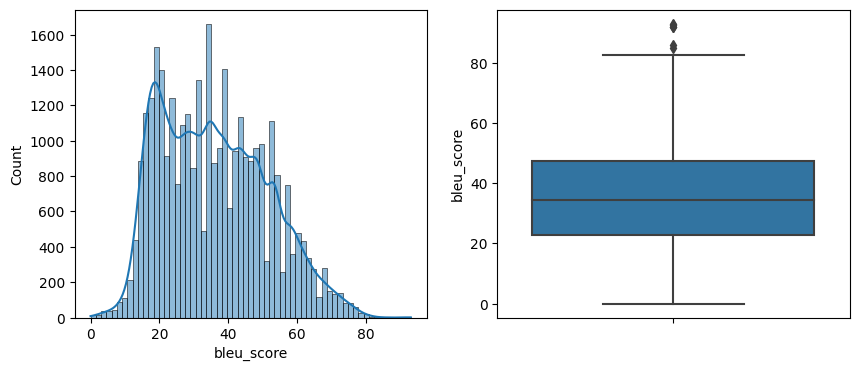

In [ ]:
## Distribution of BLEU scores for rule-based approach
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(train_processed.bleu_score, kde=True)
plt.subplot(1,2,2)
sns.boxplot(train_processed, y="bleu_score");

In [ ]:
## Sort by the BLEU score
train_processed_sorted = train_processed.sort_values("bleu_score", ascending=False)

### Check examples that went wrong

In [ ]:
train_processed_sorted.tail(20)

,input,output,ask_wh,ask_yn,ask_req,stmt,is_direct,transformed,bleu_score
5354,the flight has been cancelled.,"hi, Bob. John says that the flight has been cancelled.",False,False,False,False,False,"Hey Bob, John",2.215746
21058,find out from @SCN@ if she likes blue gowns.,"hey John, Bob wants to know if you like blue gowns.",False,False,False,False,False,"Hi Bob, John",2.215746
23734,kindly request the name of retail store on 6th street from Bob.,"hi Bob, John would like for you to provide the name of the retail store on 6th street.",False,False,False,False,False,"Hey Bob, John .",2.127337
11808,ask samantha how her new painting is coming along.,"samantha, John would like to know how your new painting is coming along.",False,False,False,False,False,"Hi Bob, John",2.042313
19626,"i'll return the bucket i took yesterday, Bob.","Bob honey, cnythia said she's definitely going to return the bucket she took yesterday.",False,False,False,False,False,"Hey Bob, John .",1.557730
31934,ask esther what she would like to do at the park this afternoon?,"Bob, your friend John. would like to know what you want to do at the park this afternoon.",True,False,True,False,False,"Hi Bob, John requests that",1.474674
15801,please ask raju about what is 26/11?,"hey raju, ajit asked for what the 26/11 is famous?",True,False,False,False,False,"Hey Bob, John",1.311191
21438,please make 30 copies of the presentation.,"hello, Bob. John has asked that you make 30 copies of the presentation.",False,False,False,False,False,"Hi Bob, John",1.046644
15996,she is taking the dog to the vet again,"hey, Bob. John says she is taking the dog to the vet again.",False,False,False,False,False,"Hey Bob, John",1.046644
20847,jean wants to invite ann for a glass of wine.,"hi, ann, jean wants to invite you for a glass of wine.",False,False,False,False,False,"Hey Bob, John",1.021157
